# Lab 6: Airline Tweets with (and without) Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab6_airline_tweets_w_embeddings.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab6_airline_tweets_w_embeddings.ipynb)

In this notebook we'll build revisit the Airline Tweets dataset (from [Lab 1](https://github.com/sgeinitz/DSML4220/blob/main/lab1_text_data.ipynb)) and compare using an MLP with one-hot encodings as the input vs using word embeddings as the input. 

In this lab there are three (3) questions/tasks. These questions are listed here but are also inline below. 

1. Q1: Choose two words to compare (different from "_wonderful_" vs "_incredible_"). Re-run the parts of the notebook that plot the histogram of the differences between learned weight parameter values for each of your chosen words across the 128 hidden units in the first layer. 
2. Q2: Add your two words the list of words whose embeddings are displayed and compared. Do your two chosen words have similar embeddings? In other words, is the distance between your embeddings very small?
3. Q3: Compare the size of the two models used in this notebook, one of which uses one-hot encoded inputs and the other which uses GloVe embeddings. 

In [ ]:
#!pip install torchtext==0.16.0

In [ ]:
#!pip install torchmetrics

In [1]:
import torch
import random
import tqdm #import notebook
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import pairwise_cosine_similarity


In [2]:
!pip3 list | grep torch

torch                     2.6.0
torchdata                 0.7.1
torchinfo                 1.8.0
torchmetrics              1.7.0
torchtext                 0.17.0
torchvision               0.21.0


In [3]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/airlinetweets.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


In [4]:
random.seed(2) 
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [5]:
df_test.shape
df.shape

(9000, 2)

Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [6]:
df.sentiment.value_counts(normalize=True)

sentiment
negative    0.653556
neutral     0.191111
positive    0.155333
Name: proportion, dtype: float64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [7]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

,sentiment,text,tokens_raw
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, i, ended, up, on, a, flight, to, la, my, fourth, time, on, standby, ., thanks, !, http://t.co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, !, i, only, loose, ', em, at, airports, ..., 1st, time, we, found, it, ., i, think, @fitbit, needs, to, make, flexes, that, stay, on, when, carrying, bags, !]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, can, take, u, to, midway-chicago, march, 8th, -, april, 6th, ., can't, make, it, then, ?, @americanair, can, get, u, to, @fly2ohare, year, round, ., #flypbi]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, is, this, how, you, let, your, employees, treat, your, loyal, customers, ?, #attackingbabymomma, #crazinessintherockies]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, so, i, still, need, to, stay, on, hold, ?, http://t.co/04sdytt7zd]"


Previously, we did not do a lot of exploratory data analysis (EDA) on this airline tweet dataset. We will not do too much here either, but at the very least let's look at a histogram of the lengths of the tweets. Note that here we are defining length to be the number of tokens, but it may also be useful to look at the number of characters. And, of course, there are other EDA steps we could do. 

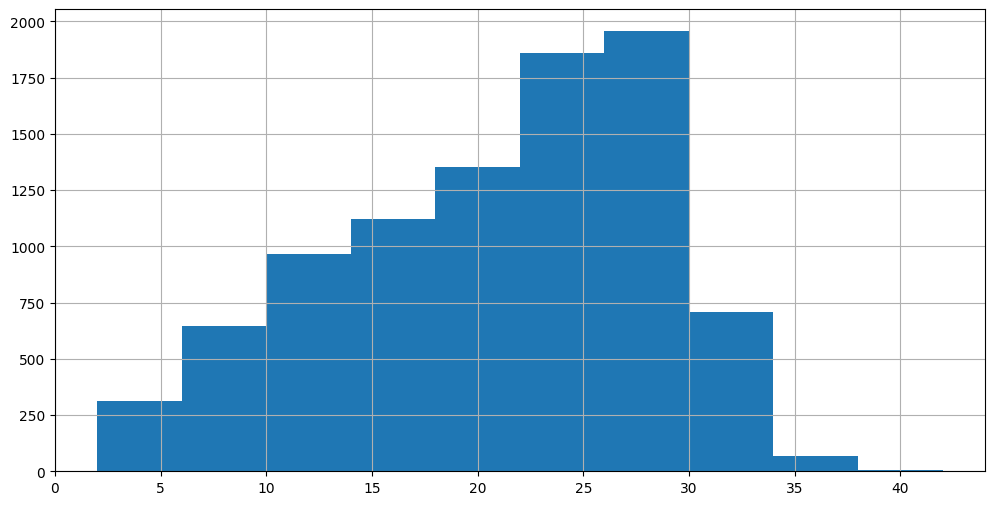

In [8]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
plt.figure(figsize=(12,6))
df['tweet_length'].hist() #bins=100, range=(0,45), width=0.9) #, df['tweet_length'].mean(), df['tweet_length'].median()
plt.show()

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lingthang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Next, let's remove common stop words (e.g. "_the_", "_in_", etc.). In this next cell we will also remove some characters/punctuation, as well as hashtag tokens. 

Note: If the following cell causes an error, then uncomment the code cell above and run it to download and load the nltk stopwords.

In [10]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

,sentiment,text,tokens_raw,tweet_length
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]",18
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]",31
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",27
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]",15
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",11


For the final step of text pre-processing we will lemmatize the tokens. Note that there are much better ways to do this but that we want to use a simple lemmatizer. For example, some lemmatizers also utilize a model internally to predict the part-of-speech for each word, since whether the word is a noun, adjective, verb, etc. will affect how lemmatization is done. Since we want to keep things simple here, and focus only on the lemmatization step, we'll assume every word is the same part of speech. Note that this is not by any means ideal (try to identify the incorrectly lemmatized token in the five tweets printed out below). In practice we would certainly utilize a 'smarter' lemmatizer.

The last step below is to combined the tokens back into a single string, which is stored in the column `textclean`. 

In [11]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lingthang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,text,tokens_raw,tweet_length,tokens,textclean
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]",18,"[@americanair, end, flight, la, fourth, time, standby, thank, http://t.co/na5g5eakpa]",@americanair end flight la fourth time standby thank http://t.co/na5g5eakpa
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]",31,"[@jetblue, thank, loose, ', em, airports, ..., 1st, time, find, think, @fitbit, need, make, flex, stay, carry, bag]",@jetblue thank loose ' em airports ... 1st time find think @fitbit need make flex stay carry bag
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",27,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",@southwestair take u midway-chicago march 8th - april 6th can't make @americanair get u @fly2ohare year round
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]",15,"[@americanair, let, employees, treat, loyal, customers]",@americanair let employees treat loyal customers
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",11,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",@usairways still need stay hold http://t.co/04sdytt7zd


Now we will perform one-hot encoding using sklearn's, `CountVectorizer`, with the option `binary=True`. We'll go ahead and call the resulting vectorized data, `X`, or `X_train` since it is only the training dataset. As with conventional statistical models, "_X_" represents the set of predictors, or independent variables.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer(binary=True, min_df=2)
X_np = count_vectorizer.fit_transform(df['textclean']).toarray()

print(f"X_np.shape = {X_np.shape}")
type(X_np)

X_np.shape = (9000, 3842)


numpy.ndarray

Here is the full vocabulary created by the the `CountVectorizer`.

In [13]:
vocab = count_vectorizer.vocabulary_
vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1], reverse=False)}
print(vocab)

{'00': 0, '000': 1, '01': 2, '02': 3, '03': 4, '05': 5, '05am': 6, '08': 7, '0hp': 8, '10': 9, '100': 10, '1000': 11, '101': 12, '1027': 13, '103': 14, '104': 15, '1081': 16, '10am': 17, '10hrs': 18, '10mins': 19, '10pm': 20, '10th': 21, '11': 22, '1109': 23, '1137': 24, '1142': 25, '117': 26, '1170': 27, '118': 28, '11am': 29, '11pm': 30, '11th': 31, '12': 32, '120': 33, '1200': 34, '1220': 35, '123': 36, '1230': 37, '1254': 38, '12pm': 39, '13': 40, '130': 41, '136': 42, '1389': 43, '13th': 44, '14': 45, '140': 46, '145': 47, '1472': 48, '15': 49, '150': 50, '152': 51, '1533': 52, '1534': 53, '1562': 54, '1571aus': 55, '15minutes': 56, '15th': 57, '16': 58, '1600': 59, '1613': 60, '1625': 61, '165': 62, '1657': 63, '17': 64, '1700': 65, '1701': 66, '174': 67, '18': 68, '180': 69, '1800': 70, '1826': 71, '1861': 72, '1898': 73, '19': 74, '1917': 75, '1970': 76, '1997': 77, '1am': 78, '1hr': 79, '1k': 80, '1m': 81, '1pm': 82, '1st': 83, '1ywxrfn0gr': 84, '20': 85, '200': 86, '2000': 87

---

### Q1: Choose two words to compare (different from "_wonderful_" vs "_incredible_"). 

Below you will choose your two words, which have similar meaning and which you suspect the model will treat similarly. Then, re-train the model and plot the histogram of the differences between learned weight values for each of your chosen words across the 128 hidden units in the first layer. Did the histograms show that the learned weight values were similar for your words? More similar than for the neighboring words compared to each other?

`<input your answer here>`

---

In [14]:
word1 = 'miserable'
word2 = 'unhappy'

word1_idx = vocab[word1]
print(f"The index for '{word1}': {word1_idx}")

word2_idx = vocab[word2]
print(f"The index for '{word2}': {word2_idx}")


The index for 'miserable': 2323
The index for 'unhappy': 3602


Next, let's look at the tweets themselves that contained the word _"great"_.

In [15]:
rows_w_word1 = np.where(X_np[:, word1_idx] == 1)[0]
print(rows_w_word1)
df.iloc[rows_w_word1,]

[1825 4409 5272 8536]


,sentiment,text,tokens_raw,tweet_length,tokens,textclean
4348,negative,@united That's real dedication &amp; concern. Your apologies don't fix the issue nor any of the miserable issues I've had over the past 6 mos.,"[@united, that's, real, dedication, &, concern, apologies, fix, issue, miserable, issues, past, 6, mos]",27,"[@united, that's, real, dedication, &, concern, apologies, fix, issue, miserable, issue, past, 6, mos]",@united that's real dedication & concern apologies fix issue miserable issue past 6 mos
2232,negative,@USAirways Past tense re help. No more. It’s been even more miserable than usual at CLT.,"[@usairways, past, tense, help, ’, even, miserable, usual, clt]",21,"[@usairways, past, tense, help, ’, even, miserable, usual, clt]",@usairways past tense help ’ even miserable usual clt
1490,negative,@united Miserable trip ... lost bag Sat... found Mon... lost again... shipping 2nd day ground Tues... might have it for return flight home,"[@united, miserable, trip, ..., lost, bag, sat, ..., found, mon, ..., lost, ..., shipping, 2nd, day, ground, tues, ..., might, return, flight, home]",27,"[@united, miserable, trip, ..., lose, bag, sit, ..., find, mon, ..., lose, ..., ship, 2nd, day, grind, tues, ..., might, return, flight, home]",@united miserable trip ... lose bag sit ... find mon ... lose ... ship 2nd day grind tues ... might return flight home
26,negative,@USAirways your a miserable airline and your loss of revenue is a reflection of that. Go extinct. A merger only delays the inevitable,"[@usairways, miserable, airline, loss, revenue, reflection, go, extinct, merger, delays, inevitable]",25,"[@usairways, miserable, airline, loss, revenue, reflection, go, extinct, merger, delay, inevitable]",@usairways miserable airline loss revenue reflection go extinct merger delay inevitable


In [16]:
rows_w_word2 = np.where(X_np[:, word2_idx] == 1)[0]
print(rows_w_word2)
df.iloc[rows_w_word2,]

[ 111  144  641  749 1081 1177 3051 4045 5589 5833 6769 7288 7609]


,sentiment,text,tokens_raw,tweet_length,tokens,textclean
3687,negative,"@AmericanAir but, what I can always rely on when I fly USAir or American is that employees will be rude and unhappy.","[@americanair, ,, always, rely, fly, usair, american, employees, rude, unhappy]",24,"[@americanair, ,, always, rely, fly, usair, american, employees, rude, unhappy]","@americanair , always rely fly usair american employees rude unhappy"
9501,negative,@united unhappy with your new mileage rules :( - was my main reason to keep flying united. Will have to take my business elsewhere,"[@united, unhappy, new, mileage, rules, :(, -, main, reason, keep, flying, united, take, business, elsewhere]",25,"[@united, unhappy, new, mileage, rule, :(, -, main, reason, keep, fly, unite, take, business, elsewhere]",@united unhappy new mileage rule :( - main reason keep fly unite take business elsewhere
6158,negative,"@JetBlue You have very unhappy customer. After waiting 20 min on hold, rude &amp; uncaring rep has now frozen my acct. can't print bdng pass!","[@jetblue, unhappy, customer, waiting, 20, min, hold, ,, rude, &, uncaring, rep, frozen, acct, can't, print, bdng, pass]",29,"[@jetblue, unhappy, customer, wait, 20, min, hold, ,, rude, &, uncaring, rep, freeze, acct, can't, print, bdng, pass]","@jetblue unhappy customer wait 20 min hold , rude & uncaring rep freeze acct can't print bdng pass"
7871,negative,@united I'm afraid not... I fly or service every week and I'm just unhappy..spend too much money to be unhappy,"[@united, afraid, ..., fly, service, every, week, unhappy, .., spend, much, money, unhappy]",23,"[@united, afraid, ..., fly, service, every, week, unhappy, .., spend, much, money, unhappy]",@united afraid ... fly service every week unhappy .. spend much money unhappy
7959,negative,@USAirways Cancelled Flightled due to maintenance. The plane was there for 10 hours. Get your shit together because there are a lot of people unhappy.,"[@usairways, cancelled, flightled, due, maintenance, plane, 10, hours, get, shit, together, lot, people, unhappy]",28,"[@usairways, cancel, flightled, due, maintenance, plane, 10, hours, get, shit, together, lot, people, unhappy]",@usairways cancel flightled due maintenance plane 10 hours get shit together lot people unhappy
6813,negative,"@AmericanAir but, what I can always rely on when I fly USAir or American is that employees will be rude and unhappy.","[@americanair, ,, always, rely, fly, usair, american, employees, rude, unhappy]",24,"[@americanair, ,, always, rely, fly, usair, american, employees, rude, unhappy]","@americanair , always rely fly usair american employees rude unhappy"
6043,negative,@united No but u cld explain how such a disorganized and inefficient company w surly and obviously unhappy employees stays in business.,"[@united, u, cld, explain, disorganized, inefficient, company, w, surly, obviously, unhappy, employees, stays, business]",23,"[@united, u, cld, explain, disorganize, inefficient, company, w, surly, obviously, unhappy, employees, stay, business]",@united u cld explain disorganize inefficient company w surly obviously unhappy employees stay business
1281,negative,@united on 4124 arriving two hours Late Flight into CLT. Now sitting on the tarmac while they move a plane from the gate. Unhappy customer.,"[@united, 4124, arriving, two, hours, late, flight, clt, sitting, tarmac, move, plane, gate, unhappy, customer]",28,"[@united, 4124, arrive, two, hours, late, flight, clt, sit, tarmac, move, plane, gate, unhappy, customer]",@united 4124 arrive two hours late flight clt sit tarmac move plane gate unhappy customer
530,negative,@united : Unhappy with United's service?\n\nRead Ralph Nader's open letter to UAL's CEO.\n\nLeave a comment or RT.\n\nhttp://t.co/O0745APIau,"[@united, :, unhappy, united's, service, read, ralph, nader's, open, letter, ual's, ceo, leave, comment, rt, http://t.co/o0745apiau]",23,"[@united, :, unhappy, united's, service, read, ralph, nader's, open, letter, ual's, ceo, l

Confirm that the input, `X`, has n rows and a column for each word (token) in the vocabulary. 

In [17]:
X = torch.tensor(X_np).float()
X.size()

torch.Size([9000, 3842])

In [18]:
# look at one observation and see how may tokens there are (i.e. how many 1's are in the row, and how many 0's)
pd.DataFrame(X_np[1,:]).value_counts()

0
0    3827
1      15
Name: count, dtype: int64

In [19]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'neutral': 1, 'negative': 2}


In [20]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [21]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([0., 0., 0.,  ..., 0., 0., 0.])

Confirm that there are no NaN, and that all numerical values are finite. 

In [22]:
dataset[:]['x'].numpy()[0,:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [23]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [24]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

#### Hyperparameters for model with one-hot encoded inputs

In [25]:
batch_size = 32
learning_rate = 0.001
num_epochs = 20
device = 'cpu'

Take one quick look at the size of the training and validation splits.

In [26]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# create the dataset, model and define loss function and optimizer
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
model = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)
loss_fun = nn.CrossEntropyLoss()#weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
dataset.set_split('train')
print(len(dataloader) * batch_size)
dataset.set_split('val')
print(len(dataloader) * batch_size)

7680
1376


In [28]:
from tqdm.notebook import tqdm

epoch_bar = tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()


    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    running_loss_val = running_loss_val / len(dataset)


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/239 [00:00<?, ?it/s]

split=val:   0%|          | 0/42 [00:00<?, ?it/s]

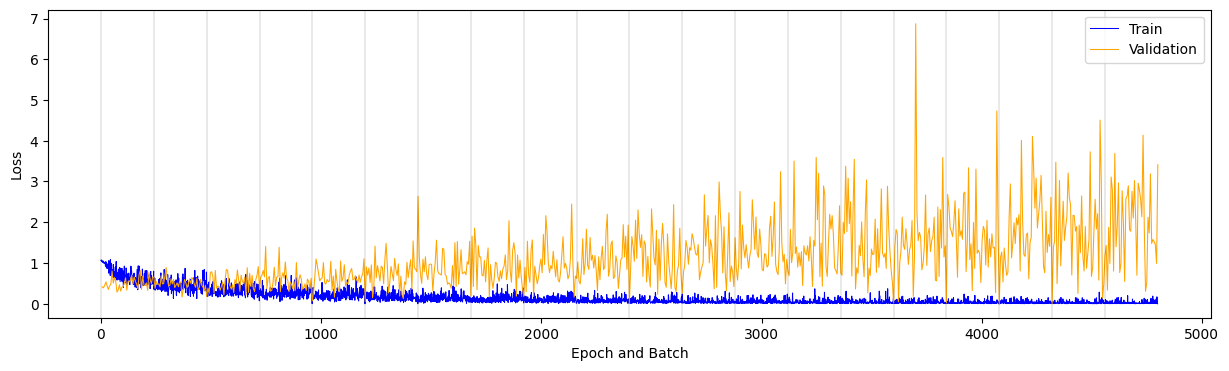

In [29]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

note that the training loss is decreasing while the validation loss is erratic. This is a sign of overfitting, meaning that the model is learning every detail in the training data, including the noise

In [30]:
# Test the model on full validation set
dataset.set_split('val')

y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")
	 

Accuracy (on 1376 validation tweets): 80.22%


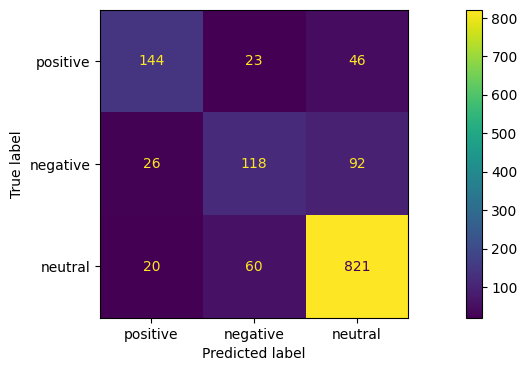

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [32]:
import torchinfo
torchinfo.summary(model, tuple(dataset[0]['x'].size()))

Layer (type:depth-idx)                   Output Shape              Param #
AirlineTweetClassifier                   [3]                       --
├─Linear: 1-1                            [128]                     491,904
├─Linear: 1-2                            [32]                      4,128
├─Dropout: 1-3                           [32]                      --
├─Linear: 1-4                            [3]                       99
Total params: 496,131
Trainable params: 496,131
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 63.10
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 1.98
Estimated Total Size (MB): 2.00

Let's now retrieve the weight parameters that are associated with the words (i.e. tokens) that have similar meaning, "great", "amazing", "incredible". These words were in the vocabulary at following locations.
* index for 'great': 4140
* index for 'incredible': 4608
* index for 'terrific': 7896

In [33]:
fc1_weights = model.fc1.weight.data
print(f"first model layer has weight matrix with shape = {fc1_weights.shape}")

first model layer has weight matrix with shape = torch.Size([128, 3842])


In [34]:
#wonderful_idx = vocab['wonderful']
#incredible_idx = vocab['incredible']
unit_i = 0
print(f"word1 index: {word1_idx}")
print(f"  fc1_weights[{unit_i},{[word1_idx-1,word1_idx, word1_idx+1]}]: {fc1_weights[unit_i,word1_idx-1:word1_idx+2]}")
print(f"word2 index: {word2_idx}")
print(f"  fc1_weights[{unit_i},{[word2_idx-1,word2_idx, word2_idx+1]}]: {fc1_weights[unit_i,word2_idx-1:word2_idx+2]}")

word1 index: 2323
  fc1_weights[0,[2322, 2323, 2324]]: tensor([0.0772, 0.0584, 0.0852])
word2 index: 3602
  fc1_weights[0,[3601, 3602, 3603]]: tensor([0.0501, 0.1521, 0.1053])


In [35]:
diffs = {"cont1":[], "word1_vs_word2":[], "cont2":[]}
for i in range(128):
    diffs["cont1"].append(abs(fc1_weights[i,word1_idx-1] - fc1_weights[i,word2_idx-1]))
    diffs["word1_vs_word2"].append(abs(fc1_weights[i,word1_idx] - fc1_weights[i,word2_idx]))
    diffs["cont2"].append(abs(fc1_weights[i,word1_idx+1] - fc1_weights[i,word2_idx+1]))

# convert each list to a numpy array
for key in diffs:
    diffs[key] = np.array(diffs[key])

In [36]:
# generate summary statistics for the differences for weight values 
diffs_df = pd.DataFrame(diffs)
diffs_df.describe()

,cont1,word1_vs_word2,cont2
count,128.000000,128.000000,128.000000
mean,0.024631,0.062695,0.049479
std,0.015405,0.025179,0.026340
min,0.000249,0.001850,0.000866
25%,0.011754,0.046371,0.029538
50%,0.024362,0.065782,0.045570
75%,0.034623,0.080348,0.064518
max,0.088117,0.114918,0.122386


In [37]:
vocab = count_vectorizer.vocabulary_

# find which key vocab is associated with the index 4139
for key, value in vocab.items():
    if value == word1_idx-1:
        w_at_incredible_idx_minus_1 = key
        print(f"word at index {word1_idx-1}: {key}")
    if value == word2_idx-1:
        w_at_wonderful_idx_minus_1 = key
        print(f"word at index {word2_idx-1}: {key}")
    if value == word1_idx+1:
        w_at_incredible_idx_plus_1 = key
        print(f"word at index {word1_idx+1}: {key}")
    if value == word2_idx+1:
        w_at_wonderful_idx_plus_1 = key
        print(f"word at index {word2_idx+1}: {key}")



word at index 3603: unhelpful
word at index 3601: unfriendly
word at index 2324: miserably
word at index 2322: miracle


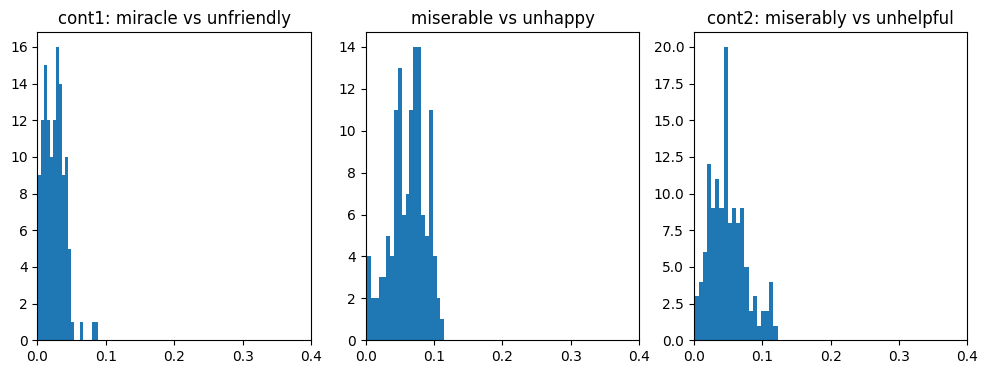

In [38]:
# plots of the differences as three different histograms
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(diffs["cont1"], bins=20)
# set x-axis limits to be the same for all three plots
plt.xlim(0,0.4)
plt.title(f"cont1: {w_at_incredible_idx_minus_1} vs {w_at_wonderful_idx_minus_1}")
plt.subplot(1,3,2)
plt.hist(diffs["word1_vs_word2"], bins=20)
plt.xlim(0,0.4)
plt.title(f"{word1} vs {word2}")
plt.subplot(1,3,3)
plt.hist(diffs["cont2"], bins=20)
plt.xlim(0,0.4)
plt.title(f"cont2: {w_at_incredible_idx_plus_1} vs {w_at_wonderful_idx_plus_1}")
plt.show()


In [39]:
# length of an input is
len(dataset[0]['x'])

3842

In [49]:
# import torchtext as text
# vec = text.vocab.GloVe(name='6B', dim=50)
import numpy as np

def load_glove_embeddings(file_path, dim=50):
    embeddings = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == dim:
                embeddings[word] = vector
    return embeddings

embedding = load_glove_embeddings('glove.6B/glove.6B.50d.txt', dim=50)
print(embedding['hello'])  # Example

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


---

### Q1: Choose two words to compare (different from "_wonderful_" vs "_incredible_"). 

Below you will choose your two words, which have similar meaning and which you suspect the model will treat similarly. Then, re-train the model and plot the histogram of the differences between learned weight values for each of your chosen words across the 128 hidden units in the first layer. Did the histograms show that the learned weight values were similar for your words? More similar than for the neighboring words compared to each other?

`<input your answer here>`

---

In [51]:
embeddings_dict = load_glove_embeddings('glove.6B/glove.6B.50d.txt', dim=50)

examples = ['annoy', 'annoyed', 'disappointed', 'sad', 'happy', 'pilot', 'attendant', 'crew', 
            'suitcase', 'luggage', 'carryon', 'great', 'amazing', 'terrific', 'incredible', 'wonderful']

vectors = [embeddings_dict[word] if word in embeddings_dict else np.zeros(50) for word in examples]
embeddings = torch.tensor(vectors)

# First embedding
embeddings[0, :]  # Tensor of shape [50]

/var/folders/22/hdrqs83s5z94vp_xg1v9l_180000gn/T/ipykernel_17456/2045283914.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  embeddings = torch.tensor(vectors)


tensor([ 0.2346, -0.4768,  0.6346, -0.3647, -0.2198, -0.4554,  0.7078,  1.0140,
        -0.9116,  0.4700, -0.2297,  0.6649,  0.7675, -0.1076,  0.0037,  0.8933,
        -0.0952, -0.0524,  0.8839, -0.4915, -0.3554, -0.1999,  0.0198,  0.8199,
         1.0315, -0.6998, -0.2933, -0.4718,  0.8706, -1.0971, -0.6342,  1.1884,
        -0.0337, -0.3884, -0.4684,  0.0881, -0.1675, -0.4079, -0.3784, -0.1425,
         0.2098,  0.1734,  0.1954,  0.6891,  1.0228,  0.2353,  0.1960, -0.2608,
        -0.0890,  0.5791])

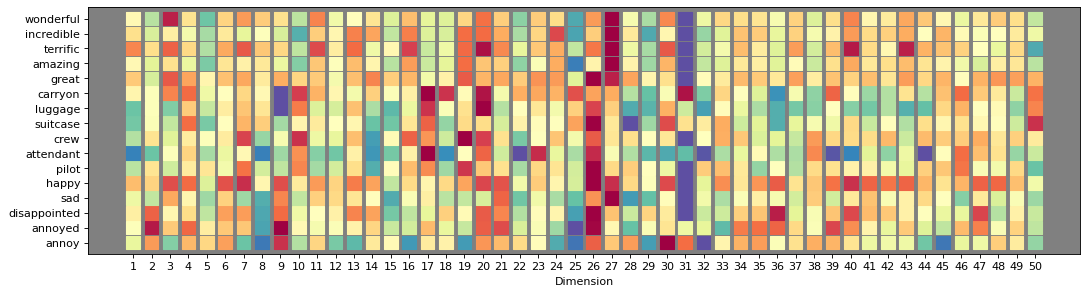

In [52]:
def compare_words_with_colors(vecs, wds):
    wdsr = wds[:]
    wdsr.reverse()
        
    dim = len(vecs[0])
    
    fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vecs):
        ax.scatter(range(dim), [i]*dim, c=vecs[i], cmap='Spectral', s=150, marker='s')
    
    plt.xticks(range(50), [i+1 for i in range(50)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    plt.show()

compare_words_with_colors(embeddings, examples)
#examples.reverse()

In [53]:
similarities = pairwise_cosine_similarity(embeddings, zero_diagonal=False)
distances = 1 - similarities 
print(f"the first row of the distance matrix for our set of words looks like: {distances[0,:]}")
pairwise_top = pd.DataFrame(
    distances,
    columns = examples,
    index = examples
)

the first row of the distance matrix for our set of words looks like: tensor([1.7881e-07, 4.3455e-01, 7.1622e-01, 7.6653e-01, 7.2499e-01, 1.1374e+00,
        8.8526e-01, 1.1141e+00, 1.0229e+00, 9.5620e-01, 9.6831e-01, 9.7373e-01,
        9.7172e-01, 9.3245e-01, 9.6144e-01, 8.6686e-01])


In the cell above we created a distance matrix, let's now see what it looks like. Note that since we are plotting pairwise distances, larger values will be red and will suggest that the word the corresponding row is far away from the word in the corresponding columns (and vice versa).

Similarly, words that are similar to each other will have a smaller distance (close to zero), and will be plotted in green. 

<Axes: >

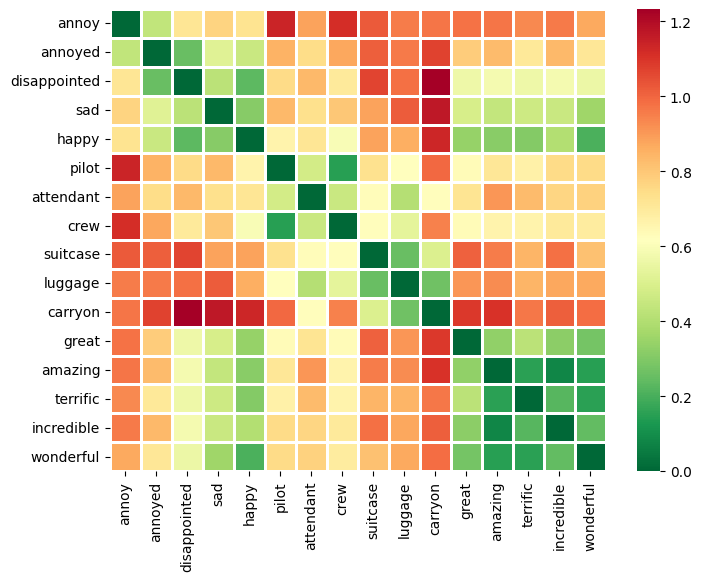

In [54]:
plt.figure(figsize=(8,6))
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("mako", as_cmap=True)
sns.heatmap(
    pairwise_top,
    cmap='RdYlGn_r',  # Reverse the 'RdYlGn' colormap to have green for larger values and red for smaller values
    linewidth=1
)


In [55]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/airlinetweets.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


In [56]:
random.seed(2) 
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [57]:
df.sentiment.value_counts(normalize=False)

sentiment
negative    5882
neutral     1720
positive    1398
Name: count, dtype: int64

In [60]:
import re

def basic_english_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

df['tokens_raw'] = df['text'].apply(basic_english_tokenizer)

In [61]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
#plt.figure(figsize=(12,6))
#df['tweet_length'].hist() #bins=100, range=(0,45), width=0.9) #, df['tweet_length'].mean(), df['tweet_length'].median()
#plt.show()

In [62]:
df.iloc[rows_w_word1,].index.sort_values()

Index([26, 1490, 2232, 4348], dtype='int64')

In [64]:
tweet_i = 53
tokens = df['tokens_raw'][tweet_i]
vectors = [embeddings_dict.get(token, np.zeros(50)) for token in tokens]
tweet_embeddings = torch.tensor(vectors)

print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")

for i, token in enumerate(tokens):
    print(f"    token, '{token}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: positive
tweet_embeddings.shape = torch.Size([20, 50])
    token, 'usairways' (at pos  0) has tweet_embeddings[:5] = tensor([ 0.5428, -0.0426,  0.0333, -0.1076, -1.1631], dtype=torch.float64)
    token, 'great' (at pos  1) has tweet_embeddings[:5] = tensor([-0.0266,  1.3357, -1.0280, -0.3729,  0.5201], dtype=torch.float64)
    token, 'job' (at pos  2) has tweet_embeddings[:5] = tensor([-0.2034, -0.0452,  0.2335, -0.5929,  0.4968], dtype=torch.float64)
    token, 'today' (at pos  3) has tweet_embeddings[:5] = tensor([ 2.7751e-04,  4.2673e-01, -8.2938e-02,  2.7601e-01,  6.4721e-01],
       dtype=torch.float64)
    token, 'from' (at pos  4) has tweet_embeddings[:5] = tensor([ 0.4104,  0.1134,  0.0515, -0.5383, -0.1291], dtype=torch.float64)
    token, 'your' (at pos  5) has tweet_embeddings[:5] = tensor([-0.0292,  0.8177,  0.3847, -0.7786,  1.1049], dtype=torch.float64)
    token, 'team' (at pos  6) has tweet_embeddings[:5] = tensor([-0.6280,  0.1225, -0.3914,  0.

In [65]:
df.iloc[rows_w_word2,].index.sort_values()

Index([530, 1281, 3687, 5847, 6043, 6158, 6813, 7719, 7871, 7959, 8603, 8839,
       9501],
      dtype='int64')

In [67]:
tweet_i = 18
tokens = df['tokens_raw'][tweet_i]
vectors = [embeddings_dict.get(token, np.zeros(50)) for token in tokens]
tweet_embeddings = torch.tensor(vectors)

print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")

for i, token in enumerate(tokens):
    print(f"    token, '{token}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: positive
tweet_embeddings.shape = torch.Size([23, 50])
    token, 'united' (at pos  0) has tweet_embeddings[:5] = tensor([-0.3987,  0.0720, -0.0698,  0.1471,  0.1185])
    token, 'this' (at pos  1) has tweet_embeddings[:5] = tensor([ 0.5307,  0.4012, -0.4078,  0.1544,  0.4778])
    token, 'flight' (at pos  2) has tweet_embeddings[:5] = tensor([ 1.7306,  0.2840, -0.0406, -0.0874, -0.4819])
    token, 'has' (at pos  3) has tweet_embeddings[:5] = tensor([0.5482, 0.0388, 0.1013, 0.3132, 0.0955])
    token, 'been' (at pos  4) has tweet_embeddings[:5] = tensor([ 0.9288, -0.7246,  0.0681, -0.3816, -0.0387])
    token, 'amazing' (at pos  5) has tweet_embeddings[:5] = tensor([-0.0131,  0.4220, -0.2632,  0.3422,  0.9992])
    token, 'this' (at pos  6) has tweet_embeddings[:5] = tensor([ 0.5307,  0.4012, -0.4078,  0.1544,  0.4778])
    token, 'is' (at pos  7) has tweet_embeddings[:5] = tensor([ 0.6185,  0.6425, -0.4655,  0.3757,  0.7484])
    token, 'the' (at pos  8) has 

The tweet above had 9 tokens in it, which we can quickly confirm here by looking at the shape of it:

In [68]:
tweet_embeddings.shape

torch.Size([23, 50])

Before we continue we must decide what a good length will be for a max-length of the number of tokens to keep. Let's look at a histogram of the lenghts of each tweet (where length equals the number of raw tokens).

In [69]:
def meanTweetEmbeddings(raw_tokens, max_len=35, dim=50):
    emb_sum = torch.zeros(dim)
    n_embs = 0
    for i, token in enumerate(raw_tokens[:max_len]):
        vec = embeddings_dict.get(token, np.zeros(dim))
        if np.abs(vec).sum() > 0:
            emb_sum += torch.tensor(vec)
            n_embs += 1
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros(dim)
    if torch.isnan(emb_avg).any():
        print(f"NaN found in embedding: {emb_sum}")
    return emb_avg

X_int = df['tokens_raw'].apply(lambda x: meanTweetEmbeddings(x)).values
print(f"X_int.shape = {X_int.shape}")
X_int[:2]

X_int.shape = (9000,)


array([tensor([ 0.3357,  0.2344,  0.0176,  0.0756,  0.2035, -0.1931, -0.4688, -0.0201,
               -0.0965, -0.0494, -0.0654,  0.0734, -0.4853, -0.0286,  0.4065, -0.0861,
               -0.3395, -0.1244, -0.4872, -0.2765,  0.0606,  0.2543,  0.0650, -0.0619,
               -0.0126, -1.3508,  0.0051,  0.1162,  0.2666, -0.2389,  3.0220,  0.2921,
               -0.4625,  0.2245,  0.0140, -0.1475,  0.2392,  0.0880,  0.1628, -0.3611,
                0.1619, -0.0134, -0.0255, -0.0635, -0.1916,  0.0108,  0.1258, -0.2281,
                0.0842,  0.1383])                                                     ,
       tensor([ 0.3500, -0.0063,  0.1625, -0.1813,  0.3026, -0.1857, -0.3449,  0.0212,
                0.0133, -0.1375,  0.0641,  0.1586, -0.3575,  0.0028,  0.3862,  0.3361,
               -0.0662,  0.0218, -0.3283, -0.4695, -0.0534,  0.1662,  0.2028,  0.0746,
                0.2152, -1.4086, -0.2648,  0.1783,  0.4110, -0.3038,  2.6626,  0.5246,
               -0.2708, -0.0042,  0.0550, 

In [70]:
X_int[0].shape

torch.Size([50])

In [71]:
if len(X_int[0] > 50):
    avg_embedding = False    
else:
    avg_embedding = True

X = torch.stack(tuple(X_int))
X.shape
#X[:2]

torch.Size([9000, 50])

There should be 9000 rows in X, since this is the number of tweets (i.e. observations) in the training data. 

The number of columns is the _embedding size_ itself. 

In [72]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'neutral': 1, 'negative': 2}


In [73]:
# Can be a good idea to occassionally check that the dims (or shapes) agree for the inputs (X) and labels (y)
assert len(X) == len(y)

In [74]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [75]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([ 0.2086,  0.2885,  0.3364,  0.0278,  0.0999, -0.3175, -0.2462,  0.0039,
        -0.1826, -0.2158, -0.0236,  0.0777, -0.1526,  0.0617,  0.3225,  0.2730,
        -0.1819, -0.0906, -0.5314, -0.2231,  0.2018,  0.1074,  0.3946,  0.1646,
         0.0064, -0.9865,  0.2171, -0.0728,  0.2255, -0.1474,  2.3210,  0.4268,
        -0.5172,  0.1603,  0.0399, -0.3661,  0.3067, -0.0640,  0.1799,  0.0231,
         0.1994,  0.0365,  0.2251,  0.0461, -0.2206,  0.2752,  0.0082, -0.0740,
        -0.0340,  0.3354])

In [76]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

#### Hyperparameters for model with GloVe embeddings

We'll use the same training configuration as before, although it is worth noting that this model would likely benefit from more training. 

In [77]:
# use same batch_size, learning_rate, and epochs as before
batch_size = 32
learning_rate = 0.001
num_epochs = 20
device = 'cpu'

In [78]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# create dataset, model and define loss function and optimizer
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
model_w_embeddings = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)
loss_fun = nn.CrossEntropyLoss()#weights)
optimizer = torch.optim.Adam(model_w_embeddings.parameters(), lr=learning_rate)

In [80]:
epoch_bar = tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model_w_embeddings.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model_w_embeddings(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()


    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model_w_embeddings.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        
        # forward (no backward step for validation data)
        outputs = model_w_embeddings(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()
    
    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    running_loss_val = running_loss_val / len(dataset)


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/239 [00:00<?, ?it/s]

split=val:   0%|          | 0/42 [00:00<?, ?it/s]

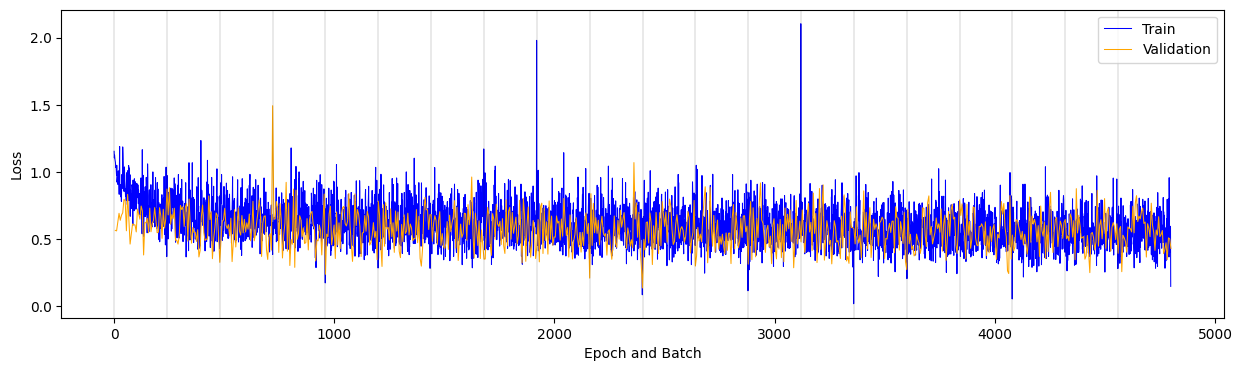

In [81]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [82]:
# Test the model
model_w_embeddings.eval()
dataset.set_split('val')
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model_w_embeddings(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")
	 

Accuracy (on 1376 validation tweets): 77.48%


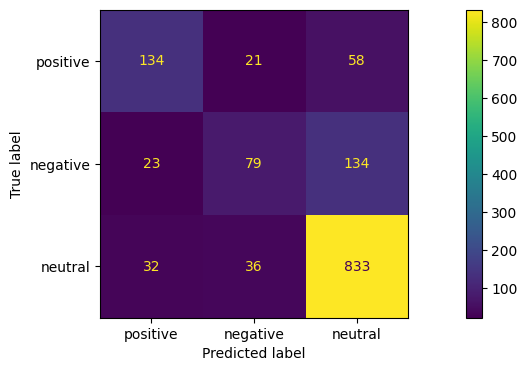

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [84]:
# length of an input is
len(dataset[0]['x'])

50

In [85]:
import torchinfo
torchinfo.summary(model_w_embeddings, tuple(dataset[0]['x'].size()))

Layer (type:depth-idx)                   Output Shape              Param #
AirlineTweetClassifier                   [3]                       --
├─Linear: 1-1                            [128]                     6,528
├─Linear: 1-2                            [32]                      4,128
├─Dropout: 1-3                           [32]                      --
├─Linear: 1-4                            [3]                       99
Total params: 10,755
Trainable params: 10,755
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [86]:
50*128 + 128

6528

---

### Q3: How much smaller is the model with embeddings than the model with one-hot encoded inputs? 


`<input your answer here>`

---